# Предсказание уровней воды на реке Амур

In [1]:
!pipenv shell
!pipenv --where
!python --version

Shell for /home/gldsn/.local/share/virtualenvs/aij20-flood-lIcseS5N already activated.
No action taken to avoid nested environments.
/home/gldsn/Projects/aij20-flood
Python 3.8.5


In [2]:
import pickle
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import os
#from fbprophet import Prophet
#from fbprophet.diagnostics import cross_validation, performance_metrics

In [12]:
path_to_data = '../datasets/'

In [13]:
targets = ('06005', '06022', '06296', '06027', '05004', '05012', '05024', '05805')

In [14]:
predict_period = ['2017-11-01', '2017-11-11'] 
f_day = datetime.strptime(predict_period[0], '%Y-%m-%d') 
l_day = datetime.strptime(predict_period[1], '%Y-%m-%d')
predict_ndays = (l_day - f_day).days

In [15]:
asunp = gpd.read_file('http://asunp.meteo.ru/geoits-rest/services/asunp/geo.json', driver='GeoJSON')

In [21]:
def gauge_info(identifier):
    gauge = asunp[asunp.meteo == identifier]
    try:
        return gauge.iloc[0]
    except:
        return None

In [22]:
posts = asunp[asunp.gidro.isin(targets) & (asunp.ktoCategory.isin(['post_gidro', 'station_gidro']))].sort_values(by=['lon']).set_index('gidro', drop=False)

## Гидропосты

Считываем архив для интересующих гидропостов

In [26]:
def read_hydro_archive(identifier):
    dateparse = lambda x: datetime.strptime(x, '%d.%m.%Y')
    df = pd.read_csv(os.path.join('../datasets/hydro', f'{identifier}_daily.csv'),
                encoding='cp1251',
                sep=';',
                dtype={'water_code': str},
                skiprows=2, index_col=0, 
                names=['stage_avg', 'stage_min', 'stage_max', 'water_temp', 'water_code', '_'],
                date_parser=dateparse,
                skipinitialspace=True
    )
    df.drop('_', axis=1, inplace=True)
    df['identifier'] = identifier
    df['stage_max'] = pd.to_numeric(df.stage_max, errors='coerce')
    df['stage_min'] = pd.to_numeric(df.stage_max, errors='coerce')
    df['water_temp'] = pd.to_numeric(df.stage_max, errors='coerce')
    df['water_code'] = df.water_code.str.strip().str.split(', ')
    df = df[~df.index.duplicated(keep='last')]
    df.resample('D').agg({
        'stage_max': 'max',
        'stage_min': 'min',
        'water_temp': 'mean'
    })
    return df.sort_index()

In [27]:
hydro = pd.concat([read_hydro_archive(i) for i in targets])

In [28]:
hydro

,stage_avg,stage_min,stage_max,water_temp,water_code,identifier
1984-01-01,80.0,80.0,80.0,80.0,[3],06005
1984-01-02,76.0,76.0,76.0,76.0,[3],06005
1984-01-03,70.0,70.0,70.0,70.0,[3],06005
1984-01-04,69.0,69.0,69.0,69.0,[3],06005
1984-01-05,69.0,69.0,69.0,69.0,[3],06005
...,...,...,...,...,...,...
2017-12-27,68.0,72.0,72.0,72.0,[16],05805
2017-12-28,81.0,83.0,83.0,83.0,[16],05805
2017-12-29,68.0,75.0,75.0,75.0,[16],05805
2017-12-30,62.0,67.0,67.0,67.0,[16],05805


<AxesSubplot:>

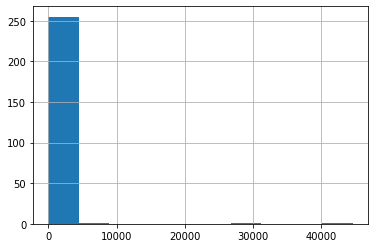

In [30]:
hydro["water_code"].value_counts().hist()

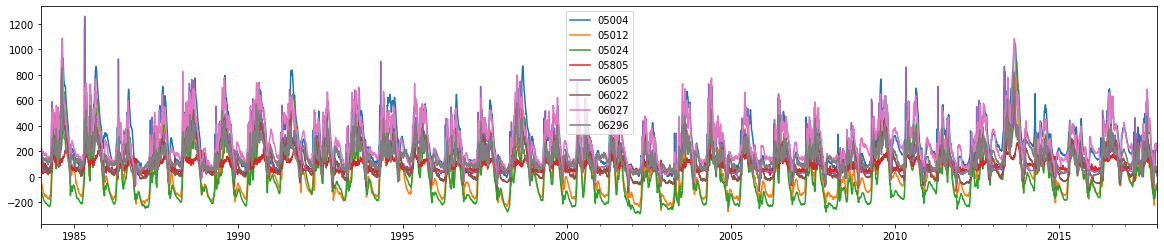

In [31]:
hydro[hydro.identifier.isin(targets)].groupby('identifier').stage_max.plot(figsize=(20, 4))
plt.legend()
plt.show()

Данные из архива с 1984 по 2018 годы прошли контроль качества, более поздние данные получены на основе оперативных данных, проверки на качество не проводились

In [47]:
nh = pd.read_csv(path_to_data + 'hydro_2018-2020/new_data_target.csv', sep=';', parse_dates=['time'], index_col=['identifier', 'time'])\
       .rename({'max_level': 'stage_max'}, axis=1)

In [48]:
nh = nh.groupby([
    pd.Grouper(level='identifier'), 
    pd.Grouper(level='time', freq='D')]
).max()

In [49]:
nh

stage_max
identifier time                 
5004       1984-01-01      112.0
           1984-01-02      118.0
           1984-01-03      134.0
           1984-01-04      149.0
           1984-01-05      156.0
...                          ...
6296       2020-05-08      151.0
           2020-05-09      141.0
           2020-05-10      130.0
           2020-05-11      117.0
           2020-05-12      107.0

[105857 rows x 1 columns]

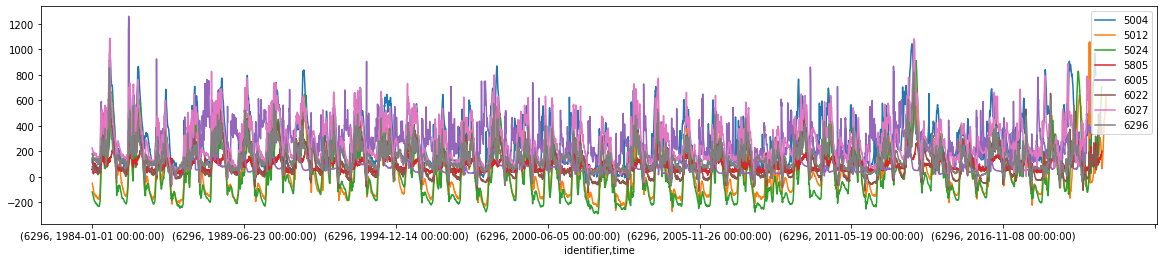

In [50]:
nh.groupby(level='identifier').stage_max.plot(figsize=(20, 4))
plt.legend()
plt.show()

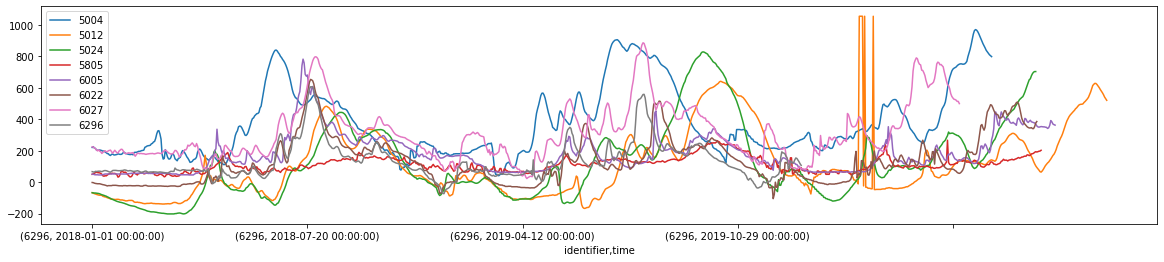

In [51]:
nh[nh.index.get_level_values('time') > '2017-12-31'].groupby(level='identifier').stage_max.plot(figsize=(20, 4))
plt.legend()
plt.show()

Удалим выбросы у гидрологичского поста с номером *5012*

In [52]:
nh[(nh.index.get_level_values('identifier') == 5012) & (nh.stage_max > 1000)].loc[5012:, 'stage_max'] = nh[(nh.index.get_level_values('identifier') == 5012) & (nh.stage_max > 1000)].stage_max / 10

/home/gldsn/.local/share/virtualenvs/aij20-flood-lIcseS5N/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:xlabel='time'>

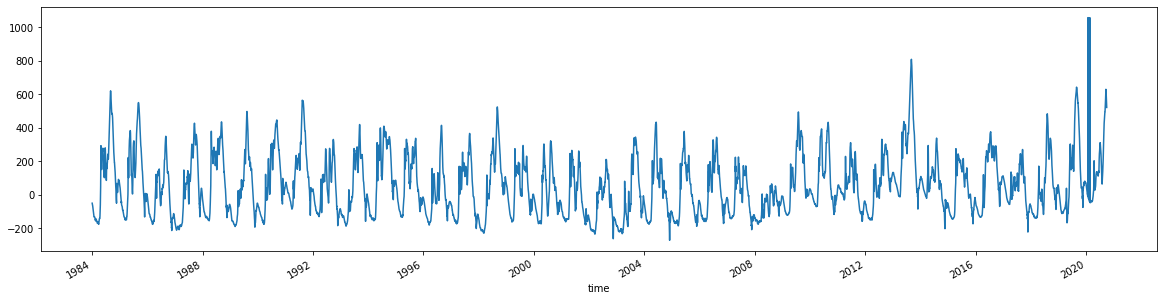

In [53]:
nh.loc[5012].stage_max.plot(figsize=(20, 5))

### Метео

In [54]:
meteo = ('5271881', '5202771', '5082931', '4991581', '4961191', '4943011', '5091561', '4953661', '5522471', '5293891', '5043101', '5343001', '4393311', '5151831', '5402191', '5133931', '4483281', '5123681', '5473051', '4713431', '5313301', '5093231', '5163331', '4982991', '4593371', '5013361', '5011811', '4853511', '4483421', '5012951', '5043841', '4773621', '4473211', '4513351', '5143511', '5042911', '5472891', '5131961', '4653531', '4803521', '4962801', '4263131', '5233401', '5172691', '4783561', '4971271', '4443141', '5123301', '4423391', '5242991', '4863711', '5211881', '4923811', '5302871', '5161671', '4993461', '5442741', '4433331', '4553341', '5091791', '5031911', '4923521', '5041651', '5244051', '5233581', '4433241', '5243651', '5312641', '5402401', '5013211', '4943321', '4553551', '5283171', '5352391', '5282001', '5092851', '5152811', '4981841', '5282601', '5032761', '5253091', '4951111', '5031331', '5352581', '5352241', '5171761', '4443211', '5091891', '5093821', '5313601', '5372731', '4961731', '5502681', '5402291', '4683431', '5162881', '5231771', '5174021', '5053701', '5342161', '4763481', '4543431', '4403131', '4773751', '4883591', '4962871', '4613541', '5082731')

In [56]:
meteo_archives = []
def load_meteo_archive(m):
    df = pd.read_csv(f'./datasets/meteo/{m}.csv', sep=';', index_col='time', parse_dates=['time'])
    # Агрегируем значения за день, для температуры возьмём среднее, для осадков сумму
    df_daily = df[['precipitation_amount', 'temperature_air', 'temperature_ground']]\
    .resample('D')\
    .agg({
        'precipitation_amount': 'sum',
        'temperature_air': 'mean', 'temperature_ground': 'mean'
    })
    info = gauge_info(m)
    df_daily['lat'] = info['lat']
    df_daily['lon'] = info['lon']
    df_daily['identifier'] = df.station_id.iloc[0]
    return df_daily.reset_index()
m = pd.concat(map(load_meteo_archive, meteo))

In [57]:
m.reset_index()

,index,time,precipitation_amount,temperature_air,temperature_ground,lat,lon,identifier
0,0,1985-01-01,0.0,-35.8625,-38.5750,52.70,118.8,5271881
1,1,1985-01-02,1.0,-31.6625,-32.2750,52.70,118.8,5271881
2,2,1985-01-03,0.0,-34.6375,-38.3125,52.70,118.8,5271881
3,3,1985-01-04,0.0,-38.0375,-41.8500,52.70,118.8,5271881
4,4,1985-01-05,0.0,-37.2375,-40.4625,52.70,118.8,5271881
...,...,...,...,...,...,...,...,...
1256533,12413,2018-12-27,0.0,-18.9125,-20.7625,50.78,127.3,5082731
1256534,12414,2018-12-28,0.0,-19.3375,-21.2750,50.78,127.3,5082731
1256535,12415,2018-12-29,0.0,-18.2125,-18.9875,50.78,127.3,5082731
1256536,12416,2018-12-30,0.0,-17.5375,-17.6625,50.78,127.3,5082731


#### Кригинг

Геостатическая интерполяция метеопараметров в точках гидропостов

In [58]:
from pykrige.ok import OrdinaryKriging

ModuleNotFoundError: No module named 'pykrige'

In [ ]:
posts[['lat', 'lon']]

In [ ]:
for day, stations in df.groupby('time'):
    longitudes = stations.lon
    latitudes = stations.lat
    for prop in ['precipitation_amount', 'temperature_air', 'temperature_ground']:
        values = stations[prop].fillna(stations[prop].mean())
        if values.max() == values.min():
            interpolated_values = np.full(len(posts), values.mean())
        else:
            OK = OrdinaryKriging(
                longitudes,
                latitudes,
                values,
                variogram_model='spherical',
                coordinates_type="geographic"
            )
            interpolated_values, ss1 = OK.execute("points", posts.lon, posts.lat, backend="C", n_closest_points=3)
        for postid, val in zip(posts.index, interpolated_values):
            nh.loc[(int(postid), day), prop] = val

## Prophet

In [262]:
def metrics(true, pred, station_id, printit=False):
    mae = np.mean(np.abs(pred - true))   
    if printit:
        print("MAE: {}".format(mae))
    return mae

In [ ]:
def plot_predict(obsrvd, fcst, station_id):
    plt.figure(figsize=(20, 4))
    plt.plot(fcst.ds, fcst.yhat, 'k')
    plt.plot(obsrvd.ds, obsrvd.y, 'b')
    plt.fill_between(fcst.ds, fcst.yhat_lower, fcst.yhat_upper, color='b', alpha=0.2)
    leg = ['true values', 'predict values']
    plt.legend(leg)
    if station_id is not None:
        plt.title(station_id)
    plt.show()

In [55]:
def is_spring(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 3 and date.month <= 5)

def is_summer(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 6 and date.month <= 9)

MAE: 38.66292338611166


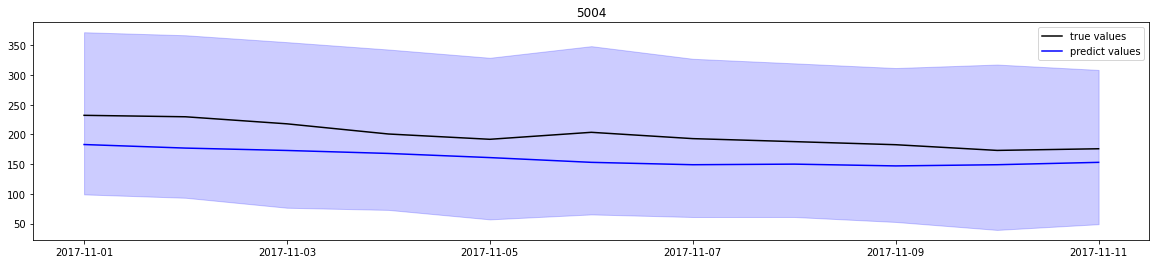

MAE: 77.45567994990395


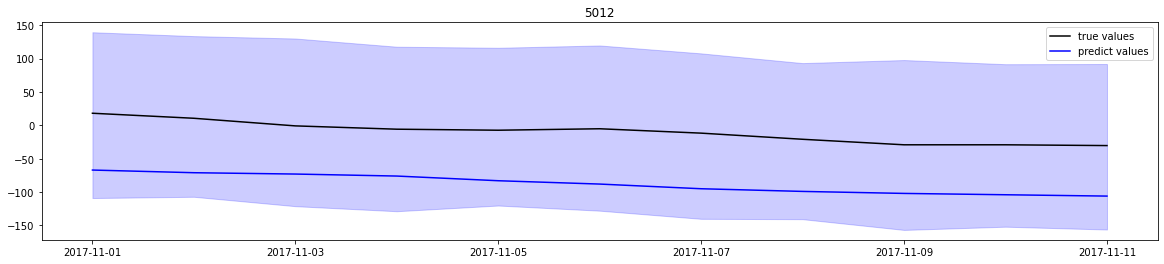

MAE: 127.53770463151399


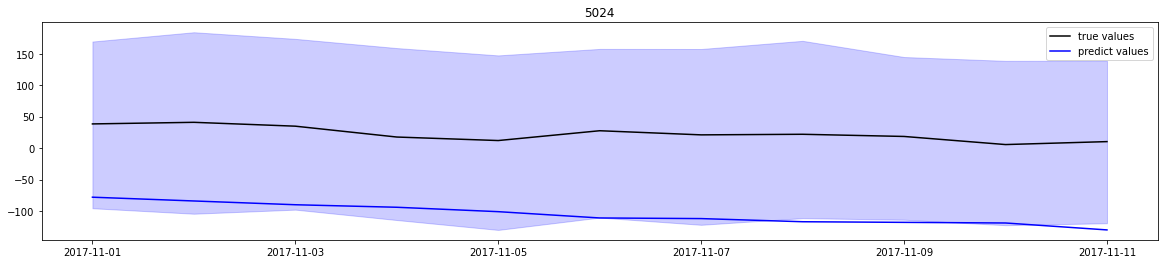

MAE: 29.89412384547037


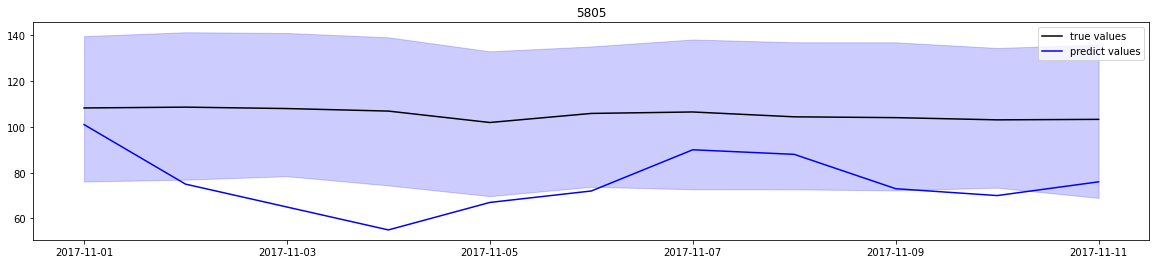

MAE: 14.875317385016325


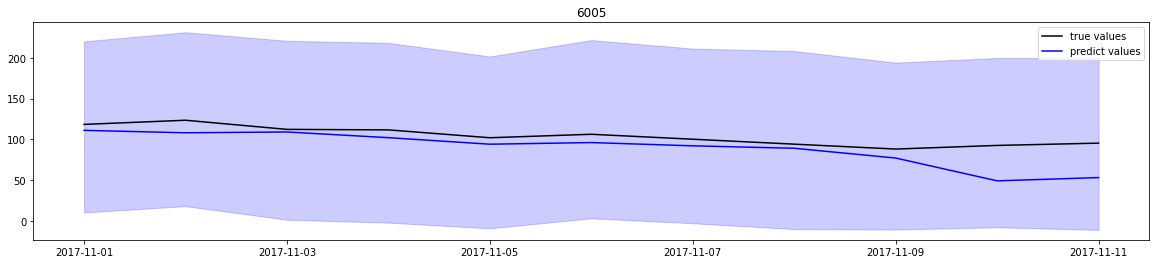

 50%|████▉     | 128/257 [30:19<30:33, 14.21s/it]
MAE: 10.872290220524633


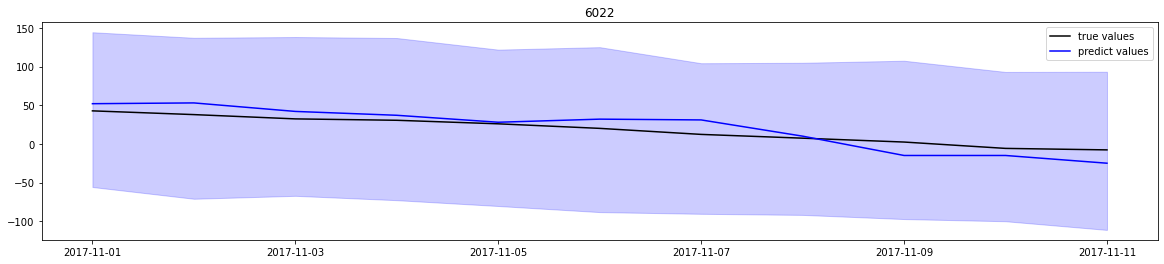

MAE: 17.141629423140554


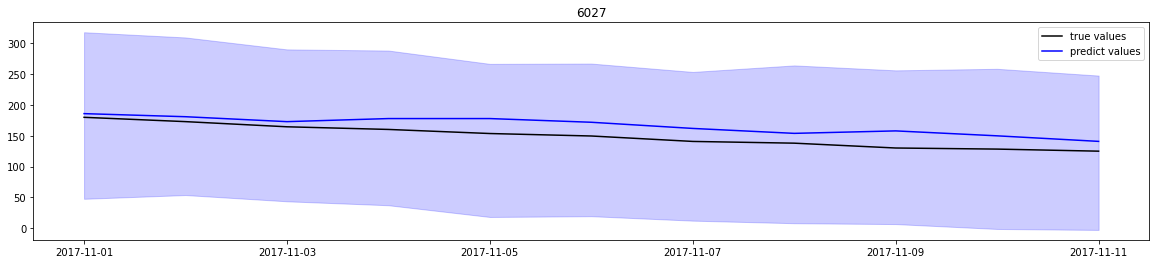

MAE: 9.748088890822116


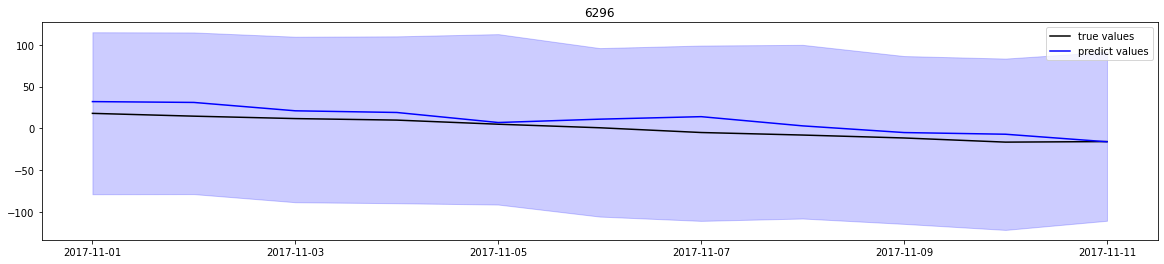

In [277]:
for identifiier, ts in nh.groupby(level='identifier'):
    ts = ts.reset_index().rename({'time': 'ds', 'stage_max': 'y'}, axis=1)

    ts['spring'] = ts['ds'].apply(is_spring)
    ts['summer'] = ts['ds'].apply(is_summer)

    p = Prophet(
        growth='linear',
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        holidays=None,
        seasonality_prior_scale=10,
        changepoint_prior_scale=.05,
        mcmc_samples=0
    )
    # мусоны
    p.add_seasonality(name='Monsoon',
                    period=120,
                    fourier_order=10,
                    prior_scale=10,
                    mode='multiplicative')
    p.add_seasonality(name='Spring', period=30.5, fourier_order=5, condition_name='spring')
    p.add_seasonality(name='Summer', period=30.5, fourier_order=5, condition_name='summer')
    p.add_regressor('precipitation_amount')
    p.add_regressor('temperature_air')
    p.add_regressor('temperature_ground')

    p.fit(ts[ts['ds'] < f_day].dropna())
    with open(f'models/{identifiier}.pkl', "wb") as f:
        pickle.dump(p, f)

    test = ts[(ts.ds >= f_day) & (ts.ds <= l_day)]
    future = test.drop('y', axis=1)
    forecast = p.predict(future)

    metrics(test.y.values, forecast.yhat.values, identifiier, True)
    plot_predict(test[['ds', 'y']], forecast, identifiier)

    # df_cv = cross_validation(p, horizon='90 days')
    # df_p = performance_metrics(df_cv)
    # print(df_p.head(5))

## Прогноз погоды

In [2]:
import xarray as xr
from siphon.catalog import TDSCatalog
from datetime import datetime, timedelta

In [3]:
def get_weather_forecast(start, end):
    """прогноз погоды глобальной модели GFS
    """
    tz = 'Europe/Moscow'
    forecastvariables = ['Temperature_isobaric', 'Temperature_surface', 'Precipitation_rate_surface']

    gfs_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog'
                       '/grib/NCEP/GFS/Global_0p5deg/catalog.xml')
    latest = gfs_cat.latest
    ncss = latest.subset()
    query = ncss.query().variables(*forecastvariables)
    query.time_range(start, end).accept('netCDF4')
    nc = ncss.get_data(query)
    return nc


weather_frcst = get_weather_forecast(datetime.utcnow() + timedelta(days=1), datetime.utcnow() + timedelta(days=11))

KeyboardInterrupt: 

In [ ]:
weather_frcst

In [ ]:
fds = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))
fds = fds.sel(isobaric=100000)

In [59]:
def predict(weather_frcst):
    predictions = []
    for identifier in targets:
        point = weather_frcst.sel(lat=posts.loc[identifier].lat,
                                  lon=posts.loc[identifier].lon,
                                  method='nearest'
                                  )
        future = point.to_dataframe().reset_index()
        future = future.rename({i: "ds" for i in future.columns if i.startswith("time")}, axis=1)
        future = future.rename({
            'Temperature_surface': 'temperature_ground',
            'Temperature_isobaric': 'temperature_air',
            'Precipitation_rate_surface': 'precipitation_amount'
            }, axis=1)

        future = future.set_index('ds').resample('D')\
          .agg({
            'precipitation_amount': 'sum',
            'temperature_air': 'mean', 'temperature_ground': 'mean'
        })

        future = future.reset_index()
        future['temperature_air'] = future.temperature_air - 273.15
        future['temperature_ground'] = future.temperature_ground - 273.15

        future['spring'] = future['ds'].apply(is_spring)
        future['summer'] = future['ds'].apply(is_summer)

        with open(f'./models/{int(identifier)}.pkl', 'rb') as f:
            forecaster = pickle.load(f)
            forecast = forecaster.predict(future)
            sf = forecast.set_index('ds').yhat.rename('5012')
            predictions.append(sf)

    return predictions

In [60]:
predictions = predict(fds)

NameError: name 'fds' is not defined

In [96]:
pd.DataFrame(predictions).T

,5012,5012,5012,5012,5012,5012,5012,5012
ds,,,,,,,,
2020-10-12,168.560626,146.321410,110.657932,323.401290,374.353969,123.429772,197.624249,144.537668
2020-10-13,167.667999,137.447958,104.022633,310.268833,361.586620,113.627207,186.047062,141.087046
2020-10-14,167.515527,136.768050,102.390404,307.894123,356.020778,107.036008,179.250729,138.855601
2020-10-15,166.155111,136.401916,100.937393,304.617279,353.114072,105.876867,177.332370,136.572204
2020-10-16,164.481086,131.902940,96.402853,300.410266,345.547523,102.806576,176.646933,136.185055
2020-10-17,159.970825,130.544679,94.244628,298.544312,339.600961,96.609731,177.236775,134.947011
2020-10-18,154.129379,126.735089,91.346289,290.107069,333.562873,93.770311,177.579531,131.757656
2020-10-19,152.267495,125.270075,87.425215,287.979155,324.913138,87.978038,176.485993,131.177154
2020-10-20,145.181867,120.603327,83.892729,284.033948,322.147676,86.783616,185.451070,131.919269
